In [1]:
import os
import pandas as pd
import pickle
import collections
import matplotlib.pyplot as plt
from statistics import  mean
import math
import time
from typing import Union
%matplotlib inline

In [2]:
HOME = os.environ['HOME']
spath = f'{HOME}/webots_code/data/stats'
dpath = f'{HOME}/webots_code/data/stats/data'

## Creating Dataframe

In [3]:
def create_df(dpath:str)->pd.DataFrame:
    '''
    Creates a pandas dataframe from all the 
    pickled files
    '''
    data = pd.DataFrame(columns=['Time','Name','Model',
                                'GPS','Speed','BS'])

    for count,filename in enumerate(os.listdir(dpath)):
        ind = count
        with open(dpath+f'/{filename}','rb') as a:
            data.at[ind,'Time'] = pickle.load(a)
            data.at[ind,'Name'] = pickle.load(a)
            data.at[ind,'Model'] = pickle.load(a)
            data.at[ind,'GPS'] = pickle.load(a)
            data.at[ind,'Speed'] = pickle.load(a)
            data.at[ind,'BS'] = pickle.load(a)
        
        if (count+1)%1000 == 0:
            print(f'{count+1} samples has been added to dataframe')

    return data


In [4]:
data = create_df(dpath)

1000 samples has been added to dataframe
2000 samples has been added to dataframe
3000 samples has been added to dataframe
4000 samples has been added to dataframe
5000 samples has been added to dataframe
6000 samples has been added to dataframe
7000 samples has been added to dataframe
8000 samples has been added to dataframe
9000 samples has been added to dataframe
10000 samples has been added to dataframe
11000 samples has been added to dataframe
12000 samples has been added to dataframe
13000 samples has been added to dataframe
14000 samples has been added to dataframe
15000 samples has been added to dataframe
16000 samples has been added to dataframe
17000 samples has been added to dataframe
18000 samples has been added to dataframe
19000 samples has been added to dataframe


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19343 entries, 0 to 19342
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Time    19343 non-null  object
 1   Name    19343 non-null  object
 2   Model   19343 non-null  object
 3   GPS     19343 non-null  object
 4   Speed   19343 non-null  object
 5   BS      19343 non-null  object
dtypes: object(6)
memory usage: 1.7+ MB


In [6]:
ncars = len(data['Name'].unique())

## Distribution of samples 

<BarContainer object of 57 artists>

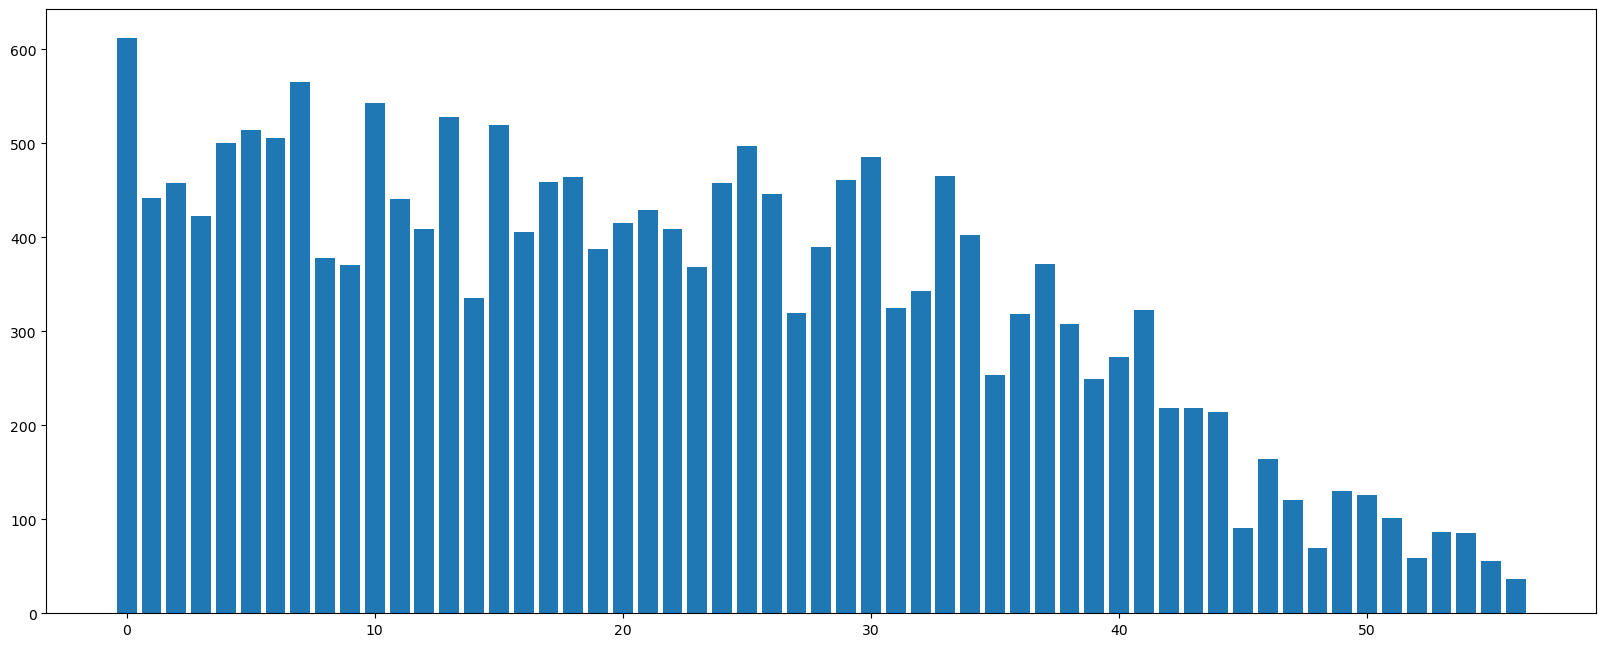

In [7]:
# Number of samples per car
car_dist = data['Name'].value_counts().to_dict()
#Sorting into list
per_car = [car_dist[f'SUMO vehicle {i}'] for i in range(0,len(data['Name'].unique()))]

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 
plt.bar(range(0,len(data['Name'].unique())),per_car)

## Average Speed

In [8]:
speed = dict()
for i in data.index.values:
    if data.at[i,'Speed'] > 100.00:
        print('Unusually high speed:',data.at[i,'Speed'],'Skipping')
        continue
    if data.at[i,'Name'] in speed.keys():
        speed[data.at[i,'Name']].append(data.at[i,'Speed'])
    else:
        speed[data.at[i,'Name']] = list()
        speed[data.at[i,'Name']].append(data.at[i,'Speed'])

Unusually high speed: 78073.19180697142 Skipping
Unusually high speed: 78085.85558321388 Skipping
Unusually high speed: 78648.48772039643 Skipping
Unusually high speed: 78457.88849706673 Skipping
Unusually high speed: 78194.37506200341 Skipping
Unusually high speed: 78754.50413971831 Skipping
Unusually high speed: 78143.35042581757 Skipping
Unusually high speed: 78068.80672991743 Skipping
Unusually high speed: 78102.58255860116 Skipping
Unusually high speed: 77858.93109594486 Skipping
Unusually high speed: 78134.47762469958 Skipping
Unusually high speed: 78297.27460896624 Skipping
Unusually high speed: 78143.91053920519 Skipping
Unusually high speed: 78069.60613856786 Skipping
Unusually high speed: 78303.48518655091 Skipping
Unusually high speed: 78759.87233467468 Skipping
Unusually high speed: 78227.24576993138 Skipping
Unusually high speed: 78229.9879820661 Skipping
Unusually high speed: 78381.98582266626 Skipping
Unusually high speed: 78327.5200994015 Skipping
Unusually high speed: 

In [9]:
avg_speed = list()
for i in range(len(data['Name'].unique())):
    avg_speed.append(mean(speed[f'SUMO vehicle {i}']))

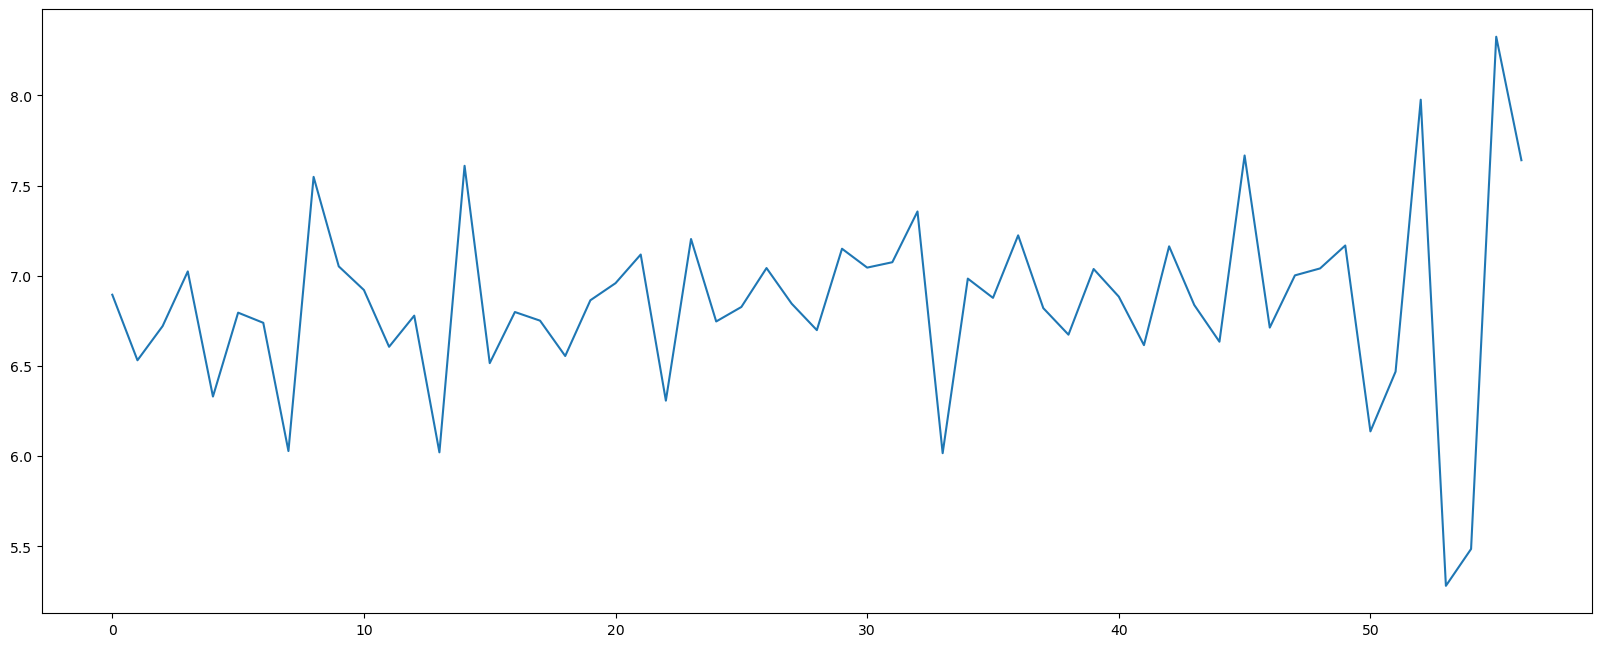

In [10]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(range(ncars),avg_speed)

## Surrounding vehicles

### For each sample
Calculating surrounding vehciles for each sample

In [11]:
timestep = 0.128
gpath = f'{HOME}/webots_code/data/stats/gps'
lrange = 120

#Creating new column for veh count and dist
data['veh_range'] = [0]*len(data)
data['veh_dist'] = [[None]]*len(data)

In [12]:
# Determining the distance between car and transmitter in meter
# TO-DO : Consider height while calculating distance
def dist_gps(gps1, gps2):
    lat1, lon1, _ = gps1
    lat2, lon2, _ = gps2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + \
        math.cos(phi_1) * math.cos(phi_2) * \
        math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

In [13]:
def read_gps(gpath)-> Union[pd.DataFrame]:
    '''
    Read all the GPS dataset and store
    it in RAM, for faster exec
    '''
    gps_pd = []
    for filename in os.listdir(gpath):
        gps_pd.append(pd.read_feather(
                        gpath+f'/{filename}'))
    
    return gps_pd

In [14]:
gps_pd = read_gps(gpath)

In [15]:
#Iterating over all the vehicle GPS data
start = time.time()
for i in data.index.values:
    siml_time = data.at[i,'Time']
    
    for gps_entry in gps_pd: 
        # Checking for the position of the vehicle in that timestep
        entry = gps_entry[
                    ((data.at[i,'Time'] - timestep) < gps_entry['timestep']) &
                    (gps_entry['timestep'] <= data.at[i,'Time'])
                    ]
        if entry.empty : 
            continue
        
        # Calculating distance between vehicles
        dist = dist_gps(data.at[i,'GPS'],entry['gps'].values[0])
        if dist < lrange:
            data.at[i,'veh_range'] +=1         #For number of vehicles in range
            data.at[i,'veh_dist'].append(dist) #Capturing the distance of each vehicle
    
    if (i)%5000 == 0:
        print(f'{i+1} samples processed',f'Time taken {time.time()-start}')

1 samples processed Time taken 0.13060808181762695
5001 samples processed Time taken 473.0565755367279
10001 samples processed Time taken 944.2749214172363
15001 samples processed Time taken 1416.1600816249847


In [ ]:
# Saving dataframe
savepath = f'{HOME}/webots_code/data/stats/sample_pd.feather'
data.to_feather(savepath)